In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from torch.utils.data import Dataset, random_split
import torchvision.io as io
from torchvision import transforms 
import torch
import torchvision
from torch import nn

# *Set up environment* 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True, use_metadata_server=False)

Mounted at /content/drive


In [6]:
if "google.colab" in sys.modules:
    import requests
    # Save datagenerators as file to colab working directory
    # If you are using GitHub, make sure you get the "Raw" version of the code
    url = 'https://raw.githubusercontent.com/karimassi/road-segmentation/main/src/training.py?token=AFUMR6BQXF77K7VSN3RV2BK73UJZA'
    r = requests.get(url)

    with open('training.py', 'w') as f:
        f.write(r.text)

    url = 'https://raw.githubusercontent.com/karimassi/road-segmentation/main/src/MyDataSet.py?token=AFUMR6AOHCJQRNWEIC2PSFC73UJZU'
    r = requests.get(url)
        
    with open('MyDataSet.py', 'w') as f:
        f.write(r.text)
        
    import MyDataSet
    import training 
else:
    from src import training   
    from src import MyDataSet

# *Baseline CNN Model*

In [7]:
threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

class PatchModel(nn.Module):
    """
    Model that tells if a 16 x 16 RGB (as a 3 x 16 x 16 tensor) correspond to a road (1) or not (0)
    """
    def __init__(self):
        super().__init__()
        
        # 3 channels 16 x 16
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=32,
            kernel_size=5
        )

        # 32 channels 12 x 12 (12 = 16 - (kernel_size - 1))
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # 32 channels 6 x 6 (6 = 12 / kernel_size)
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3
        )

        # 64 channels 4 x 4 (4 = 6 - (kernel_size - 1))
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        # 64 channels 2 x 2 (2 = 4 / kernel_size)
        self.lin1 = nn.Linear(
            in_features=64*2*2,
            out_features= 512
        )
        self.lin2 = nn.Linear(
            in_features=512,
            out_features=1
        )
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = x.view(-1, 64*2*2)
        x = self.relu(self.lin1(x))
        x = self.sigmoid(self.lin2(x))
        # If we are in testing mode then the output should be either 0 or 1
        if not self.training:
            x = 1 * (x > threshold)
        return x.view(-1)

# *Load the data*

In [8]:
batch_size = 100

dataset = MyDataSet.PatchedSatImagesDataset(MyDataSet.img_path, MyDataSet.gt_path, threshold)

rotations = [(45, 45), (90, 90), (135, 135), (180, 180), (-45, -45), (-90, -90), (-135, -135), (-180, -180)]
for rotation in rotations:
    dataset += MyDataSet.PatchedSatImagesDataset(MyDataSet.img_path, MyDataSet.gt_path, threshold, transforms.RandomRotation(rotation))
    
dataset += MyDataSet.PatchedSatImagesDataset(MyDataSet.img_path, MyDataSet.gt_path, threshold, transforms.RandomVerticalFlip(p = 1.0))
dataset += MyDataSet.PatchedSatImagesDataset(MyDataSet.img_path, MyDataSet.gt_path, threshold, transforms.RandomHorizontalFlip(p = 1.0))

data_len = len(dataset)
train_len = round(data_len * 0.8)
test_len = round(data_len * 0.2)

dataset_train, dataset_test = random_split(dataset, [train_len, test_len])

print(len(dataset_train), len(dataset_test))

dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=batch_size,
    shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=True
)

550000 137500


# *Learning Rate Finder*

In [ ]:
!pip install torch-lr-finder


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.50E-02


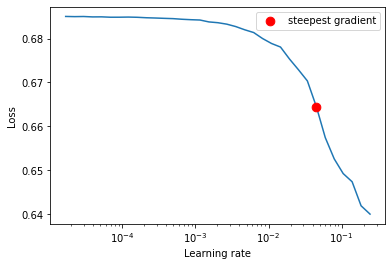

In [30]:
from torch_lr_finder import LRFinder

criterion = torch.nn.BCELoss()
model = PatchModel().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6, momentum = 0.9)

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloader_train, end_lr=1, num_iter=50)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

# *Train the model*

In [34]:
num_epochs = 50
learning_rate = 8e-2
decay_rate = 0.95

# Train the logistic regression model with the Adam optimizer
criterion = torch.nn.BCELoss()
model = PatchModel().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate, verbose=True)
training.train(model, criterion, dataloader_train, dataloader_test, optimizer, scheduler, num_epochs)

Adjusting learning rate of group 0 to 8.0000e-02.
Starting training
Adjusting learning rate of group 0 to 7.6000e-02.
Epoch  1 | Training loss : 2462.0 | Test accuracy : 0.74406 | Test F1 : 0.60793 | In 61.475 s
Adjusting learning rate of group 0 to 7.2200e-02.
Epoch  2 | Training loss : 2143.2 | Test accuracy : 0.77452 | Test F1 : 0.64104 | In 61.146 s
Adjusting learning rate of group 0 to 6.8590e-02.
Epoch  3 | Training loss : 2052.7 | Test accuracy : 0.7842 | Test F1 : 0.64722 | In 61.344 s
Adjusting learning rate of group 0 to 6.5160e-02.
Epoch  4 | Training loss : 1998.6 | Test accuracy : 0.79477 | Test F1 : 0.65076 | In 61.656 s
Adjusting learning rate of group 0 to 6.1902e-02.
Epoch  5 | Training loss : 1954.0 | Test accuracy : 0.81075 | Test F1 : 0.6613 | In 62.448 s
Adjusting learning rate of group 0 to 5.8807e-02.
Epoch  6 | Training loss : 1913.3 | Test accuracy : 0.79927 | Test F1 : 0.64424 | In 62.23 s
Adjusting learning rate of group 0 to 5.5867e-02.
Epoch  7 | Training l

([0.74405813,
  0.77451634,
  0.7842036,
  0.79477084,
  0.8107491,
  0.79926544,
  0.80744,
  0.82036364,
  0.7758472,
  0.78165823,
  0.8159127,
  0.81648004,
  0.82879996,
  0.8043927,
  0.82905453,
  0.83706176,
  0.81266904,
  0.81978905,
  0.8292655,
  0.8283127,
  0.8284219,
  0.8299927,
  0.83114904,
  0.83333087,
  0.83522916,
  0.82962906,
  0.8348581,
  0.82986903,
  0.8381163,
  0.8318764,
  0.83522916,
  0.8379782,
  0.8458764,
  0.8395563,
  0.83507633,
  0.84236366,
  0.8395127,
  0.84198546,
  0.84331644,
  0.84143996,
  0.84499633,
  0.8432873,
  0.84315646,
  0.8443418,
  0.8393673,
  0.8481527,
  0.8424146,
  0.84591264,
  0.8467709,
  0.8484509],
 [0.6079338638999245,
  0.6410381218520078,
  0.6472233504165302,
  0.6507578445781361,
  0.6613026817061685,
  0.6442435620264574,
  0.6723179785555059,
  0.6772068551236933,
  0.6464325270436027,
  0.657619231635874,
  0.6844313983483749,
  0.6834351142319766,
  0.6857008997527035,
  0.6774592862129212,
  0.69122330199588

In [37]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, '/content/drive/Shareddrives/road-segmentation/cnn_50_sgdmomentum_lr8e2_decay0.95')

In [ ]:
training.train(model, criterion, dataloader_train, dataloader_test, optimizer, scheduler, num_epochs)

Starting training
Adjusting learning rate of group 0 to 5.8478e-03.
Epoch  1 | Training loss : 621.08 | Test accuracy : 0.84965 | Test F1 : 0.70278 | In 61.741 s
Adjusting learning rate of group 0 to 5.5554e-03.
Epoch  2 | Training loss : 600.62 | Test accuracy : 0.84502 | Test F1 : 0.70146 | In 61.678 s
Adjusting learning rate of group 0 to 5.2777e-03.
Epoch  3 | Training loss : 584.57 | Test accuracy : 0.84879 | Test F1 : 0.70328 | In 61.45 s
Adjusting learning rate of group 0 to 5.0138e-03.
Epoch  4 | Training loss : 566.53 | Test accuracy : 0.8441 | Test F1 : 0.70116 | In 61.602 s
Adjusting learning rate of group 0 to 4.7631e-03.
Epoch  5 | Training loss : 550.58 | Test accuracy : 0.84823 | Test F1 : 0.70405 | In 62.491 s
Adjusting learning rate of group 0 to 4.5249e-03.
Epoch  6 | Training loss : 534.36 | Test accuracy : 0.8486 | Test F1 : 0.70323 | In 61.894 s
Adjusting learning rate of group 0 to 4.2987e-03.
Epoch  7 | Training loss : 521.49 | Test accuracy : 0.84722 | Test F1 :

# *Predict output for testing images*

In [ ]:
submission = MyDataSet.PatchedTestSatImagesDataset(MyDataSet.test_path)
dataloader_submission = torch.utils.data.DataLoader(
    submission, 
    batch_size=1,
    shuffle=False
)
with open('submission.csv', 'w') as f:
    f.write('id,prediction\n')
    model.eval()
    for img_id, X in dataloader_submission:
        X = X.to(device)
        Y = model(X).item()
        f.write(f'{img_id[0]},{Y}\n')        